In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time

In [4]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint

In [5]:
from Detection.RetinaNetEIPH import RetinaNetEIPH
from Detection.RetinaNetEIPHFocalLoss import RetinaNetEIPHFocalLoss
from data_loader import *
from callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet

In [6]:
path = Path('/data/Datasets/EIPH_WSI/')

database = Database()
database.open(str(path/'EIPH.sqlite'))

size = 1024
level = 0

In [7]:
def sampling_func(y, **kwargs):
    y_label = np.array(y[1])
    h, w = kwargs['size']

    bg_label = [0] if y_label.dtype == np.int64 else ["bg"]
    classes = bg_label + kwargs['classes']
    level_dimensions = kwargs['level_dimensions']
    level = kwargs['level']

    _bg_label_prob = 0.1  # add a backgound label to sample complete random
    _random_offset_scale = 0.5  # up to 50% offset to left and right of frame
    # calc histogram
    sample_probability = np.array([np.count_nonzero(np.array(y_label) == class_id) / len(y_label)
                                   for class_id in classes])

    non_zero_ids = (sample_probability > 0) & (sample_probability < 1)
    sample_probability[non_zero_ids] = 1 - sample_probability[non_zero_ids]
    sample_probability[0] = _bg_label_prob
    # softmax
    non_zero_ids = sample_probability > 0
    xoffset = randint(-w, w) * _random_offset_scale
    yoffset = randint(-h, h) * _random_offset_scale
    sample_probability[non_zero_ids] = np.exp(sample_probability[non_zero_ids]) \
                                       / np.sum(np.exp(sample_probability[non_zero_ids]), axis=0)
    class_id = np.random.choice(classes, 1, p=sample_probability)[0]
    if class_id == bg_label[0]:
        slide_width, slide_height = level_dimensions[level]
        xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), slide_height - h)
    else:
        # sample from a completely random image position
        ids = y_label == class_id
        xmin, ymin, xmax, ymax = np.array(y[0])[ids][randint(0, np.count_nonzero(ids) - 1)]

    return int(xmin - w / 2 + xoffset), int(ymin - h / 2 +yoffset)

In [8]:
files = []
lbl_bbox = []

getslides = """SELECT uid, filename FROM Slides"""
for currslide, filename in tqdm(database.execute(getslides).fetchall()):
    database.loadIntoMemory(currslide)

    check = True if 'erliner' in filename else False
    slidetype = 'Berliner Blau/' if check else 'Turnbull Blue/'

    slide_path = path / slidetype / filename

    slide = openslide.open_slide(str(slide_path))
    level = level#slide.level_count - 1
    level_dimension = slide.level_dimensions[level]
    down_factor = slide.level_downsamples[level]

    classes = {3: 1, 4: 2, 5: 3, 6: 4, 7: 5}#{3: 1, 4: 2, 5: 3, 6: 4, 7: 5} #
    labels, bboxes = [], []
    for id, annotation in database.annotations.items():
        if annotation.labels[0].classId in classes:
            d = 2 * annotation.r / down_factor
            x_min = (annotation.x1 - annotation.r) / down_factor
            y_min = (annotation.y1 - annotation.r) / down_factor
            x_max = x_min + d
            y_max = y_min + d
            label = classes[annotation.labels[0].classId]

            bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            labels.append(label)

    if len(bboxes) > 0:
        lbl_bbox.append([bboxes, labels])
        files.append(SlideContainer(file=slide_path, y=[bboxes, labels],
                                    level=level, width=size, height=size, sample_func=sampling_func))

  0%|          | 0/24 [00:00<?, ?it/s]

Loading DB into memory ...


  4%|▍         | 1/24 [00:00<00:06,  3.39it/s]

Loading DB into memory ...


  8%|▊         | 2/24 [00:01<00:13,  1.63it/s]

Loading DB into memory ...


 12%|█▎        | 3/24 [00:02<00:12,  1.73it/s]

Loading DB into memory ...


 17%|█▋        | 4/24 [00:02<00:10,  1.93it/s]

Loading DB into memory ...


 21%|██        | 5/24 [00:02<00:08,  2.35it/s]

Loading DB into memory ...
Loading DB into memory ...


 29%|██▉       | 7/24 [00:03<00:06,  2.75it/s]

Loading DB into memory ...


 38%|███▊      | 9/24 [00:03<00:04,  3.73it/s]

Loading DB into memory ...
Loading DB into memory ...


 46%|████▌     | 11/24 [00:03<00:02,  4.67it/s]

Loading DB into memory ...
Loading DB into memory ...


 50%|█████     | 12/24 [00:04<00:02,  4.10it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 71%|███████   | 17/24 [00:04<00:01,  4.78it/s]

Loading DB into memory ...
Loading DB into memory ...


 79%|███████▉  | 19/24 [00:05<00:00,  5.79it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 88%|████████▊ | 21/24 [00:05<00:00,  4.68it/s]

Loading DB into memory ...
Loading DB into memory ...


100%|██████████| 24/24 [00:06<00:00,  3.61it/s]

Loading DB into memory ...


In [9]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [10]:
bs = 20
train_images = 5000
val_images = 500

train_files = list(np.random.choice(files[4:], train_images))
valid_files = list(np.random.choice(files[:4], val_images))

#train_files = list(np.random.choice(files, train_images))
#valid_files = list(np.random.choice(files, val_images))

In [11]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=0,
                      max_lighting=0.0,
                      max_zoom=1.,
                      #max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.5, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [12]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min, num_workers=4).normalize()

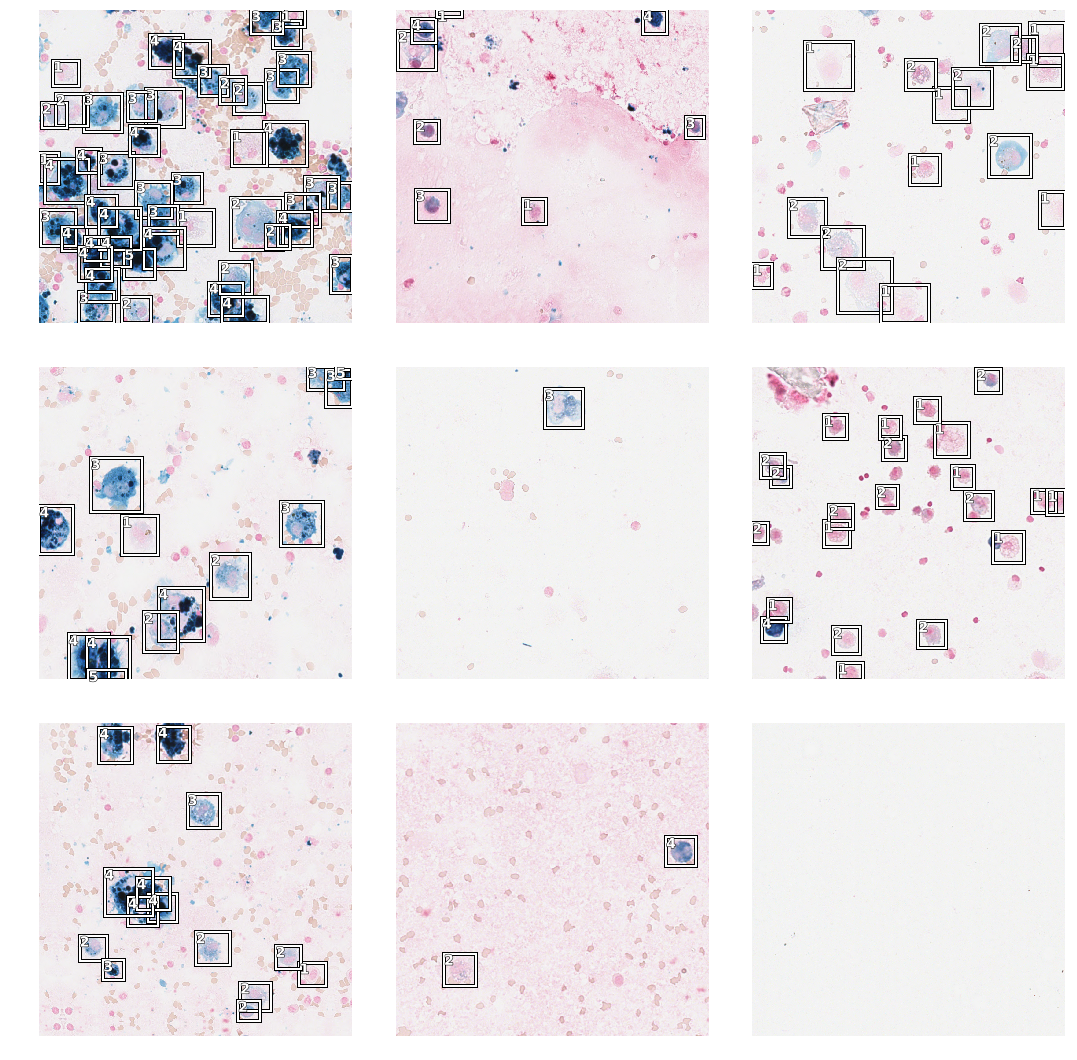

In [17]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

In [13]:
anchors_32 = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.6, 0.7, 0.9, 1.25, 1.5])

In [14]:
anchors = anchors_32

In [32]:
#anchors_16 = create_anchors(sizes=[(16,16)], ratios=[1], scales=[0.35, 0.46, 0.64])

In [33]:
#anchors = anchors_16

In [34]:
anchors.shape

torch.Size([5120, 4])

In [35]:
anchors

tensor([[-0.9688, -0.9688,  0.1500,  0.1500],
        [-0.9688, -0.9688,  0.1750,  0.1750],
        [-0.9688, -0.9688,  0.2250,  0.2250],
        ...,
        [ 0.9688,  0.9688,  0.2250,  0.2250],
        [ 0.9688,  0.9688,  0.3125,  0.3125],
        [ 0.9688,  0.9688,  0.3750,  0.3750]])

In [36]:
#anchors = torch.cat((anchors_32, anchors_16), 0)

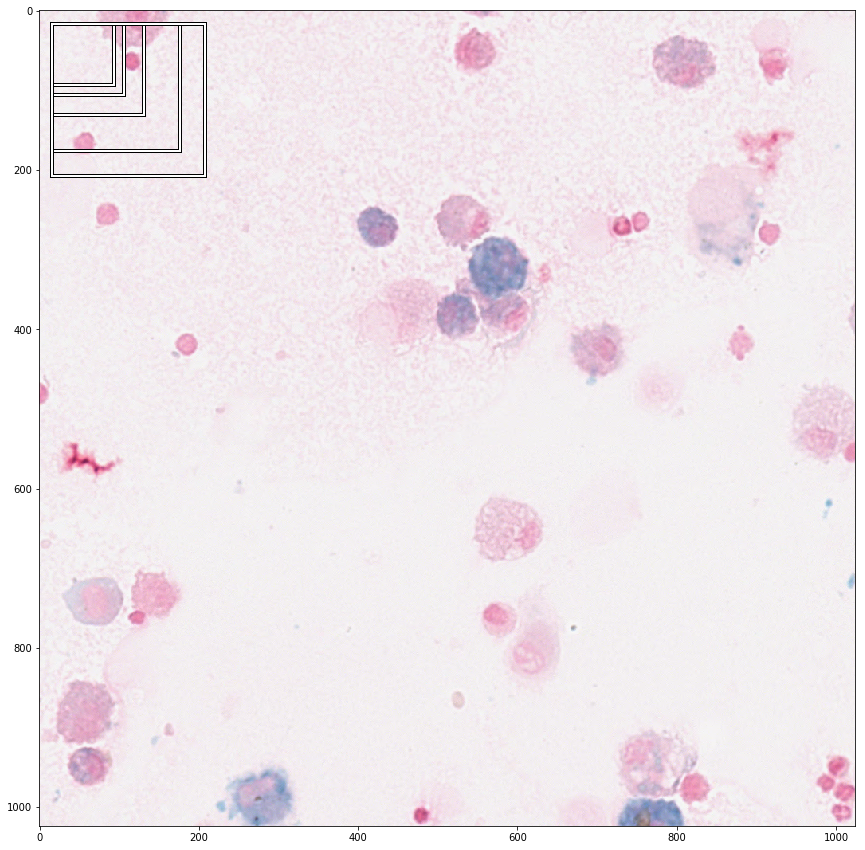

In [37]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:5]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [15]:
crit = RetinaNetEIPHFocalLoss(anchors)

In [16]:
encoder = create_body(models.resnet18, True, -2)
model = RetinaNetEIPH(encoder, n_classes=data.train_ds.c, n_anchors=5, sizes=[32], chs=128, final_bias=-4., n_conv=3)

In [17]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [18]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


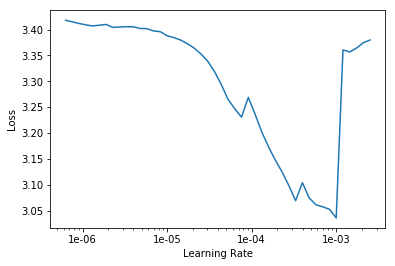

In [24]:
learn.lr_find()
learn.recorder.plot()

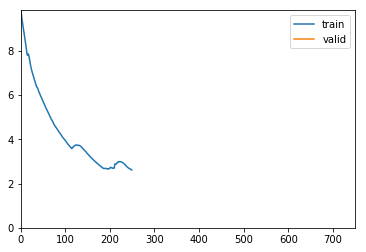

KeyboardInterrupt: 

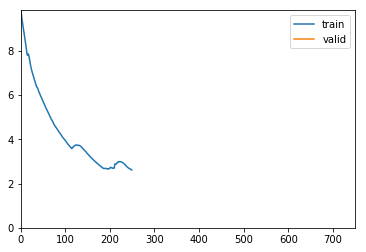

In [19]:
learn.fit_one_cycle(3, 1e-3)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

learn.save("pferd_0_1024_reg")
learn.export("pferd_0_1024_reg")

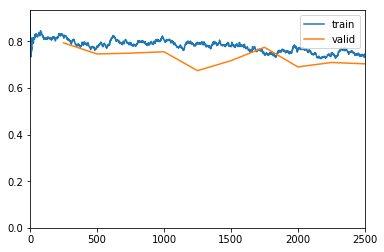

In [44]:
learn.fit_one_cycle(10, 1e-4)

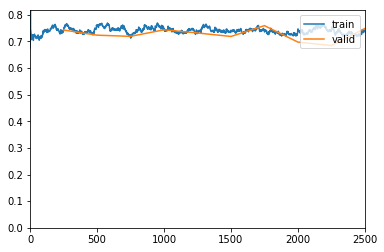

In [45]:
learn.fit_one_cycle(10, 1e-5)

In [47]:
learn.save("pferd_0_1024_reg")
learn.export("pferd_0_1024_reg")

In [200]:
classes = data.train_ds.classes

In [201]:
classes

['background', 1, 2, 3, 4, 5]

In [51]:
from data_loader import *

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


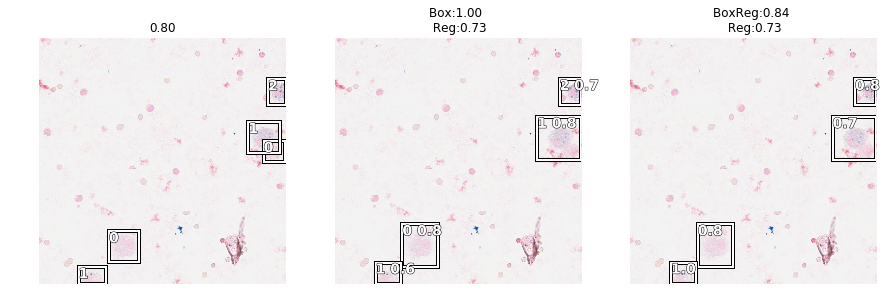

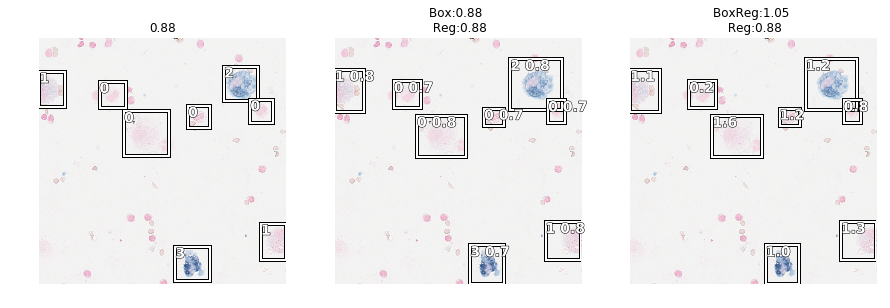

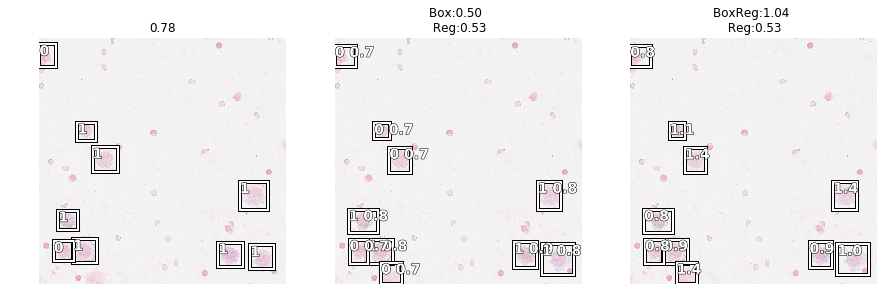

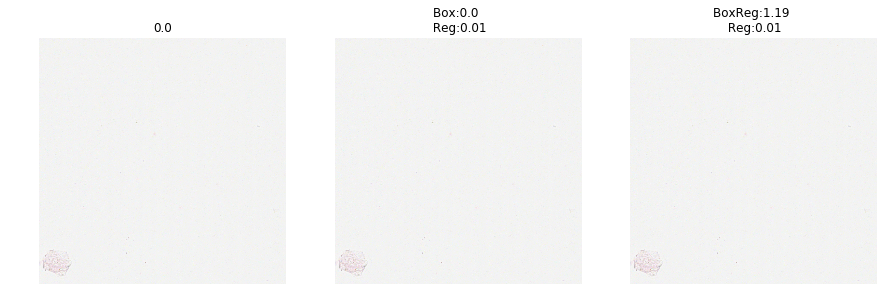

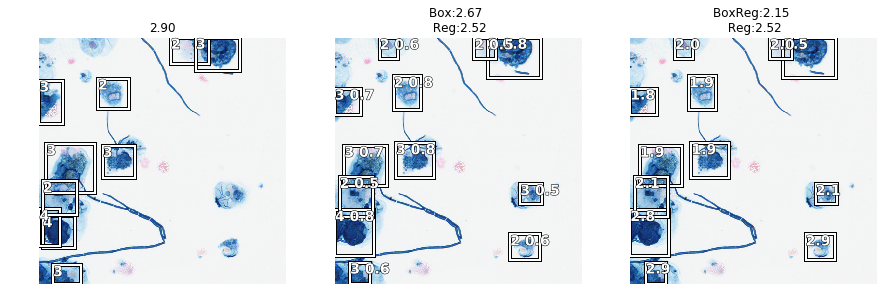

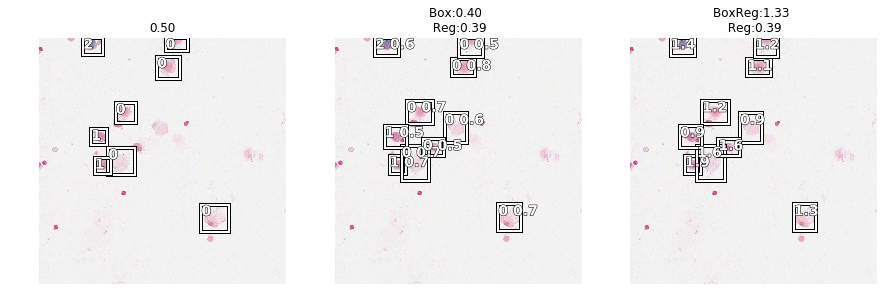

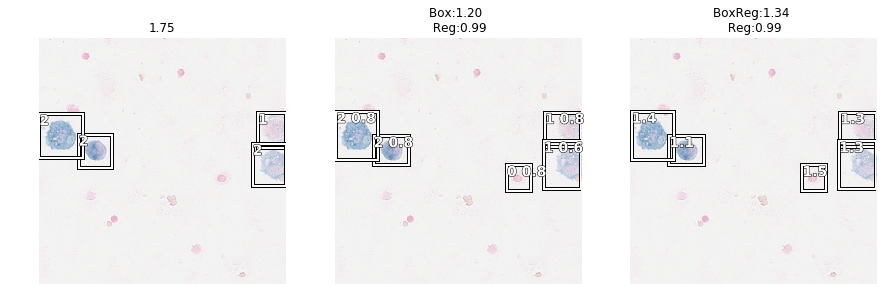

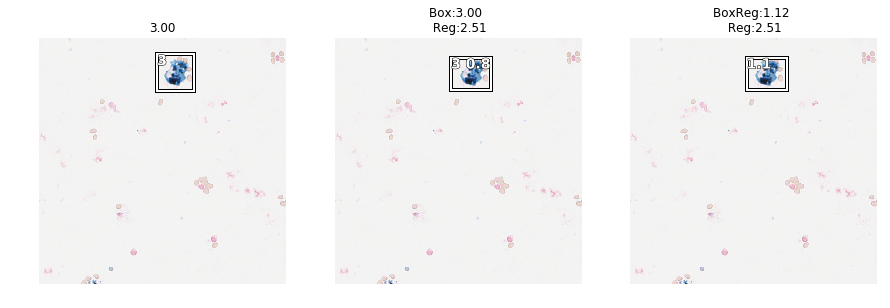

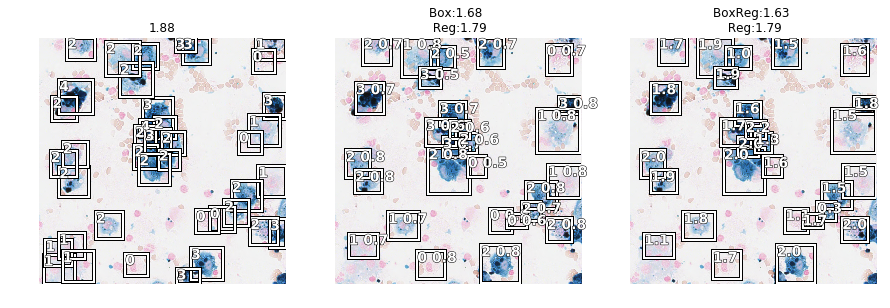

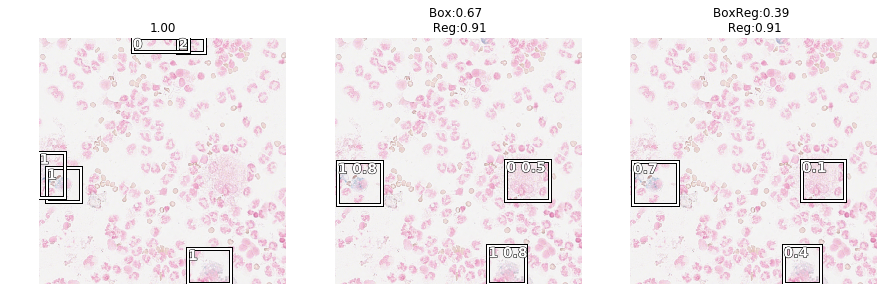

In [53]:
slide_object_result(learn, anchors, image_count=10, detect_thresh=0.5, nms_thresh=0.1)